## Стратегическая Оптимизация Товарного Ассортимента

**Аналитическая задача** — Анализ торгового ассортимента

### Задачи проекта:

- Тщательный анализ товарного ассортимента с целью выявления ключевых и дополнительных позиций.
- Формирование и проверка гипотез для оптимизации ассортиментной матрицы.

Дополнительный ассортимент -- товары, которые можно предлагать как сопутствующие или располагать в прикассовой зоне.

### Описание данных: 
|Признак | Комментарий|
|--:|:--|
|`date` | дата заказа|
|`customer_id` | идентификатор покупателя|
|`order_id` | идентификатор заказа|
|`product` | наименование товара|
|`quantity` | количество товара в заказе|
|`price` | цена товара|

### План по выполнению проекта:

Шаг 1. Загрузка данных
- Загрузка данных и предварительный анализ

Шаг 2. Подготовка данных
- Корректировка заголовков;
- Корректировка типов признаков; 
- Поиск дублей, аномальных и пропущенных значений;
- Добавление новых столбцов.

Шаг 3. Исследовательский анализ данных
- Построить диаграмму количества покупок по дням;
- Построить диаграмму, отображающую сумму покупок по дням;
- Построить гистограмму, отображающую распределение заказов по сумме.

Шаг 4. Анализ торгового асортимента
- На основании наименования товара и данных открытых внешних источников выделим 3-10 категорий товаров;
- В каждой категории распределим товары на основной и дополнительный ассортимент.

Шаг 5. Статистические гипотезы
- Сформулируем и проверим статистические гипотезы о равенстве средних чеков для выделенных категорий товаров.

Шаг 1. Загрузка данных
- Загрузка данных и предварительный анализ

##### Подключение и установка библиотек

In [53]:
# подключение библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
from scipy import stats
from scipy.stats import (shapiro, 
                         mannwhitneyu)

##### Чтение и профилирование данных  

In [54]:
# чтение данных

df = pd.read_csv('vkr_project_retail.csv')
df.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [55]:
# информация о наборе
df.info()

# описательные статистики
#per = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
#df[['quantity', 'price']].describe(percentiles=per)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


##### <u>**Результаты профилирования данных:**</u>

|Признак|Комментарий|
|:--|:--|
|`product`|скорректировать заголовок|
|`Дата`|скорректировать тип данных|
|`all`|поиск дублей|
|`all`|поиск аномалий|
|`'quantity', 'price' `|max значения слишком большие|

Шаг 2. Подготовка данных (при необходимости)
- Корректировка заголовков;
- Корректировка типов признаков; 
- Поиск дублей, аномальных и пропущенных значений;
- Добавление новых столбцов.

#### Предобработка данных

##### Корректировка заголовков

In [56]:
# для удобства переименуем столбец 'product', тк есть pandas.DataFrame.product

df.columns = ['date', 'customer_id', 'order_id', 'item', 'quantity', 'price']

# Создадим словарь для подписи заголовков рисунков

dct_columns = {'date': 'Дата',
              'customer_id': 'Id пользователя',
              'order_id': 'Id пользователя',
              'item': 'Товар',
              'quantity': 'Количество',
              'price': 'Цена',
              'purchase_sum': 'Сумма покупки'}
dct_columns;

##### Корректировка типов данных (дата)

In [57]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M')
df.dtypes;

##### Поиск и обработка дублей

In [58]:
#display(df[df[['customer_id', 'order_id', 'item', 'quantity', 'price']].duplicated()])

In [59]:
# Поиск дублей, аномальных и пропущенных значений
df[['customer_id', 'order_id', 'item', 'quantity', 'price']].duplicated().sum()  #1864
# видим, что без учета времени имеются дублирующиеся записи. Удалим их
flt_duplicated = df[['customer_id', 'order_id', 'item', 'quantity', 'price']].duplicated()
df = df.loc[~flt_duplicated].copy()

# проверка
# df[df.order_id == 68474]
print(f'После удаления дублей мы потеряли {(1864/6737):.2%} данных')
print(f'Количество дублирующихся записей - {df.duplicated().sum()}.')

После удаления дублей мы потеряли 27.67% данных
Количество дублирующихся записей - 0.


##### Поиск и обработка аномальных значений

In [60]:
# Обнаружили, что есть ряд заказов, в которых присутствуют несколько разных customer_id
# Уберем их

df.customer_id.nunique() #2451
df.order_id.nunique()    #2784

df.groupby('order_id').agg(order = ('customer_id', 'nunique'))\
                      .sort_values(by= 'order')

lst_order =  df.groupby('order_id').agg(order = ('customer_id', 'nunique'))\
                                     .sort_values(by= 'order')\
                                     .tail(29).index

for number in df.order_id:
    if number in lst_order:
        df.drop(index=df[df.order_id == number].index, inplace=True)

In [61]:
df #4873 - 4807
df.customer_id.nunique() #2394
df.order_id.nunique()    #2755
print(f'После удаления "странных" заказов мы потеряли еще {1- (4807/4873):.2%} данных')

После удаления "странных" заказов мы потеряли еще 1.35% данных


In [62]:
#Проверим даты внешний вид и посмотрим период сбора информации для исследуемой БД

df.date.agg(['min', 'max'])

min   2018-10-01 00:00:00
max   2019-10-31 01:04:00
Name: date, dtype: datetime64[ns]

In [63]:
# Посмотрим подробнее на цены и количество товара в заказах - есть слишком большие значения

per = [0.01, 0.05, 0.25, 0.5, 0.75, 0.85, 0.87, 0.95, 0.98, 0.99]

df[['quantity', 'price']].describe(percentiles= per).round(2).T

,count,mean,std,min,1%,5%,25%,50%,75%,85%,87%,95%,98%,99%,max
quantity,4807.0,2.81,17.68,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,7.0,16.00,30.00,1000.0
price,4807.0,514.87,946.46,9.0,15.0,37.0,90.0,150.0,488.0,974.0,1087.0,2205.5,3658.84,4956.52,14917.0


##### <u>**Предположение:**</u>

Вероятно, есть какие-то `оптовики или разовая покупка` по товару (max -1000 при 26.64 - 99% и 1 для 80%) или это `неверно введенные данные`

Также есть группа очень дорогих товаров (на фоне цены 50%), возможно, их следует рассмотреть отдельно (частота покупок)

In [64]:
#del df['count_order_x']

In [65]:
# Добавим столбец 'сумма покупки/заказа' и 'количество заказов'

df['purchase_sum'] = (df['quantity'] * df['price']).astype('int') 

df= pd.merge(df,
             df.groupby('customer_id').agg(count_order = ('order_id', 'nunique')).reset_index(),
             how='inner', on='customer_id')
df.head(2)

,date,customer_id,order_id,item,quantity,price,purchase_sum,count_order
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194,1


In [66]:
# Проверим, как распределены заказы 

df.groupby('customer_id').agg(count_id = ('order_id', 'nunique'))\
                         .reset_index().sort_values(by='count_id',\
                                                    ascending=False).head()  #c971fb21-d54c-4134-938f-16b62ee86d3b	

df['count_order'].agg(['max', 'min', 'median', 'mean'])


max       126.000000
min         1.000000
median      1.000000
mean        5.313709
Name: count_order, dtype: float64

##### <u>**Вывод:**</u>

В целом распределение `клиент : количество покупок` кажется адекватным, 

вопрос вызывает только пользователь с `customer_id = c971fb21-d54c-4134-938f-16b62ee86d3b` 


При исследовании можно посмотреть на тех, кто покупает:

- часто (по заказам)
- много (по позициям)
- на большие суммы

Вероятно, это магазин, который специализируется на садоводвстве, в товарной матрице много товаров-растений

!!! При работе с неделями следует учитывать, что <u>часть номеров недель будет повторяться (октябрь)<u>.


Попробуем выделить их отдельно слишком высокие значения

In [67]:
# Для начала определим аномальные значения для: quantity, purchase_sum, count_order

df.groupby('customer_id').agg(count_id = ('count_order', 'unique'))\
                         .reset_index().sort_values(by='count_id',\
                                                    ascending=False).head();  

#purchase_sum
#312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6	675000
#c971fb21-d54c-4134-938f-16b62ee86d3b	159508  +    #c971fb21-d54c-4134-938f-16b62ee86d3b	 126  #count_order/ #quantity
     
#4d93d3f6-8b24-403b-a74b-f5173e40d7db	57278
#58a4c3cc-504f-43ea-a74a-bae19e665552	53232

#146cd9bf-a95c-4afb-915b-5f6684b17444	49432
#498f12a4-6a62-4725-8516-cf5dc9ab8a3a	41900

#???
#e382d4c4-a4c9-44d3-97a0-a8868e122563 - аномальны для выборок
#db77c238-3c80-4032-9e3c-c30a43f4a650 - аномальны для выборок

In [68]:
# Создадим DF из этих клиентов, по желанию его можно рассмотреть отдельно

lst = ('312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6', 'c971fb21-d54c-4134-938f-16b62ee86d3b',
       '4d93d3f6-8b24-403b-a74b-f5173e40d7db', '58a4c3cc-504f-43ea-a74a-bae19e665552',
       '146cd9bf-a95c-4afb-915b-5f6684b17444', '498f12a4-6a62-4725-8516-cf5dc9ab8a3a')

df_anomal_max = df[(df.customer_id == '1d6c8c1f-a799-4418-9af2-1ded47d7a85c')]
for customer in lst:
    df_anomal_max = pd.concat([df_anomal_max, df[(df.customer_id == customer)]])

df_anomal_max.head(2)

,date,customer_id,order_id,item,quantity,price,purchase_sum,count_order
3528,2019-05-31 01:02:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0,120,1
3529,2019-05-31 01:02:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Белогор кассета 6 шт E6,1,120.0,120,1


In [69]:
df_anomal_max[['purchase_sum', 'quantity', ]].describe(percentiles= per).T

,count,mean,std,min,1%,5%,25%,50%,75%,85%,87%,95%,98%,99%,max
purchase_sum,220.0,4731.545455,45660.338331,22.0,59.0,110.8,240.0,696.5,1574.0,2174.00,2412.25,5266.25,13156.32,41361.05,675000.0
quantity,220.0,9.672727,71.212283,1.0,1.0,1.0,1.0,1.0,2.0,3.15,5.00,15.00,50.00,63.24,1000.0


In [70]:
np.round(df.purchase_sum.sum()/df.order_id.nunique(),2)

np.float64(1486.25)

Мы видим, что у нас есть клиенты, которых можно отнести в разряд оптовых, учитывая средний чек.

Как вариант, можно подумать об индивидуальной работе с этими клиентами: 
- система скидок, 
- доставка, 
- обработка доп потребностей (увеличение товарной матрицы по их потребностям, если это целесообразно)

In [71]:
# При желании можно убрать df_anomal_max из общих данных

#for client_id in lst:
#    index_del = df[df.customer_id == client_id ].index
#    df.drop(index=index_del, inplace=True)
df;

Теперь построим графики для нашего DF

In [72]:
# попробуем убрать аномальные значения
# построим графики для визуализации для 'quantity' и 'price'
# формула для расчета 'усов'

def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

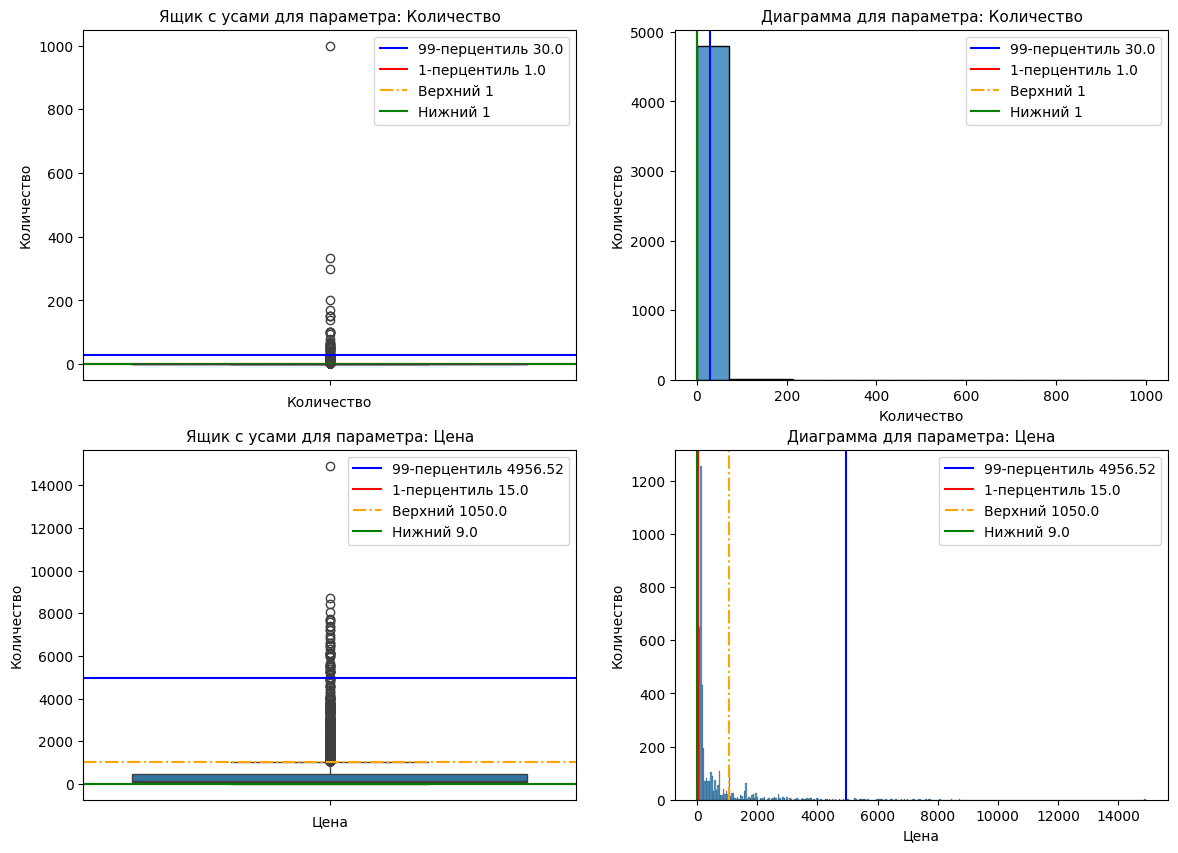

In [73]:
lst_col = ['quantity', 'price']

plt.subplots(2,2, figsize=(14,10))
for index, col in enumerate(lst_col):
    plt.subplot(2, 2, 2*index+1)
    ax = sns.boxplot(data=df, y=col)

    ax.set_xlabel(f'{dct_columns[col]}')
    ax.set_ylabel('Количество')
    ax.set_title(f'Ящик с усами для параметра: {dct_columns[col]}',
                  fontsize=11)

    per_99 = np.round(np.nanpercentile(df[col], 99), 2)
    ax.axhline(per_99, color='blue',
               label=f"99-перцентиль {per_99}")
    
    per_01 = np.round(np.nanpercentile(df[col], 1), 2)
    ax.axhline(per_01, color='red',
               label=f"1-перцентиль {per_01}")

    actual_loval, actual_hival = calc_boxplot(df[col])

    ax.axhline(actual_hival, color='orange',
               label=f"Верхний {actual_hival}",
               linestyle='dashdot')

    ax.axhline(actual_loval, color='green',
               label=f"Нижний {actual_loval}")

    plt.legend()

    plt.subplot(2, 2, 2*index+2)
    # столбцая диаграмма
    ax = sns.histplot(df[col], # bins=50, kde=True
                      )
        
    ax.set_xlabel(f'{dct_columns[col]}')
    ax.set_ylabel('Количество')
    ax.set_title(f'Диаграмма для параметра: {dct_columns[col]}'
                 , fontsize=11)

    per_99 = np.round(np.nanpercentile(df[col], 99), 2)
    ax.axvline(per_99, color='blue',
               label=f"99-перцентиль {per_99}")
    
    per_01 = np.round(np.nanpercentile(df[col], 1), 2)
    ax.axvline(per_01, color='red',
               label=f"1-перцентиль {per_01}")

    actual_loval, actual_hival = calc_boxplot(df[col])

    ax.axvline(actual_hival, color='orange',
               label=f"Верхний {actual_hival}",
               linestyle='dashdot')

    ax.axvline(actual_loval, color='green',
               label=f"Нижний {actual_loval}")
    plt.legend()

In [74]:
flt = ((df['price'].between(np.nanpercentile(df['price'], 1), 
                            np.nanpercentile(df['price'], 99))) 
       & (df['quantity'].between(np.nanpercentile(df['quantity'], 1), 
                                 np.nanpercentile(df['quantity'], 99))))

print(f"Процент потерь --- {(1 - df[flt].shape[0]/df.shape[0]):.2%}.")   

df[flt].drop(columns=['date', 'order_id', 'count_order'])\
               .describe(percentiles= per).round(2).round(2).T

Процент потерь --- 2.73%.


,count,mean,std,min,1%,5%,25%,50%,75%,85%,87%,95%,98%,99%,max
quantity,4676.0,1.94,3.25,1.0,1.00,1.0,1.0,1.0,1.0,2.0,2.0,6.0,12.0,20.00,30.0
price,4676.0,460.54,719.00,15.0,21.75,38.0,97.0,150.0,487.0,937.0,1049.0,1949.0,2999.0,3668.75,4949.0
purchase_sum,4676.0,607.33,1219.51,15.0,22.00,44.0,120.0,190.0,704.0,1087.0,1230.0,2474.0,3589.0,4216.50,47385.0


In [75]:
df[['quantity', 'price', 'purchase_sum' ]].describe(percentiles= per).round(2).T

,count,mean,std,min,1%,5%,25%,50%,75%,85%,87%,95%,98%,99%,max
quantity,4807.0,2.81,17.68,1.0,1.00,1.0,1.0,1.0,1.0,2.0,2.0,7.0,16.00,30.00,1000.0
price,4807.0,514.87,946.46,9.0,15.00,37.0,90.0,150.0,488.0,974.0,1087.0,2205.5,3658.84,4956.52,14917.0
purchase_sum,4807.0,851.80,9873.88,9.0,20.12,38.0,120.0,194.0,734.0,1199.0,1425.0,2849.0,4574.00,6148.94,675000.0


In [76]:
#df = df[(df['price'].between(np.nanpercentile(df['price'], 1),
#                             np.nanpercentile(df['price'], 99)))
#     & (df['quantity'].between(np.nanpercentile(df['quantity'], 1), 
#                               np.nanpercentile(df['quantity'], 99)))]   

In [77]:
lst_col_1 = ['quantity', 'price', 'purchase_sum' ]
for col in lst_col_1:
    display(f'Мода для {col} = {df[flt][col].agg(pd.Series.mode)[0]}')
    
print(df[flt][lst_col].agg(['median']).round(2))

'Мода для quantity = 1'

'Мода для price = 38.0'

'Мода для purchase_sum = 120'

        quantity  price
median       1.0  150.0


In [78]:
for col in lst_col_1:
    display(f'Мода для {col} = {df[col].agg(pd.Series.mode)[0]}')
    
print(df[lst_col].agg(['median']).round(2))

'Мода для quantity = 1'

'Мода для price = 38.0'

'Мода для purchase_sum = 120'

        quantity  price
median       1.0  150.0


##### <u>**Вывод:**</u>

Изучив графики (распределение усов и перцентилей ), сравнив модальные и медианные значения, а также другие описательные стартистики было решено:

аномальные значения можно не удалять, да, есть есть заказы с высокими ценами и большим количеством товара (чуть меньше 3% от выборки) -    

но для нашей задачи нет ничего критичного

##### Поиск и обработка пропусков


In [79]:
print(f'Количество пропусков - {df.isna().sum().sum()}.')

Количество пропусков - 0.


##### <u>**Результаты подготовки данных:**</u>

|Признак|Комментарий|Комментарий|
|:--|:--|:--|
|`product`|~~скорректировать заголовок~~|заголовки скорректированы|
|`Дата`|~~скорректировать тип данных~~|дата приведена к общепринятой и у нее изменился тип|
|`all`|~~поиск дублей~~|дубли удалены|
|`all`|~~поиск аномалий~~|аномалии решено не трогать|
|`'quantity', 'price' `|~~max значения слишком большие~~|выделены клиенты с высокими показателями|

Шаг 3. Исследовательский анализ данных
- Построить диаграмму количества покупок по дням;
- Построить диаграмму, отображающую сумму покупок по дням;
- Построить гистограмму, отображающую распределение заказов по сумме.

- Построить диаграмму количества покупок по дням;

In [80]:
# Добавление новых призанков

df['event_data'] = df['date'].dt.date.astype('datetime64[ns]')
df['event_month'] = df['date'].dt.strftime("%Y-%m").astype('datetime64[ns]') 

df.dtypes;

In [81]:
df_order = df.groupby('event_data')\
             .agg(count_order = ('order_id', 'nunique'))\
             .reset_index()#\
             #.sort_values(by='count_order', ascending= False
                   
df_month_order = df.groupby('event_month')\
                   .agg(count_order = ('order_id', 'nunique'))\
                   .reset_index()

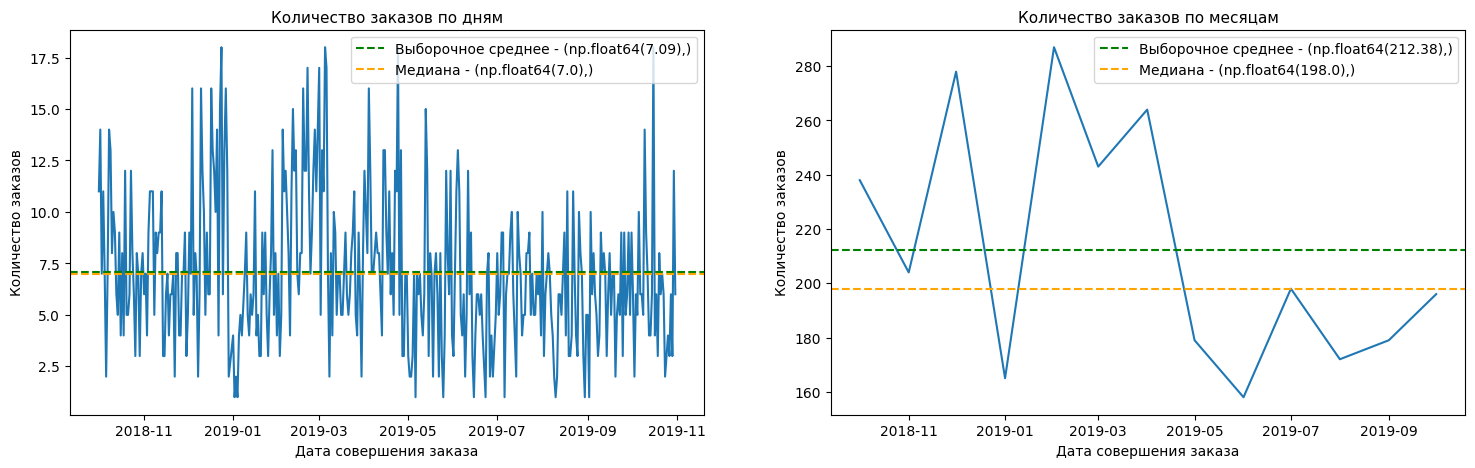

In [82]:
# по датам
plt.subplots(1,2, figsize=(18,5))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df_order,
                  x= 'event_data',
                  y= 'count_order')

ax.set_xlabel('Дата совершения заказа')
ax.set_ylabel('Количество заказов')
ax.set_title('Количество заказов по дням', fontsize=11)

ax.axhline(df_order['count_order'].mean(), linestyle='dashed', color='green',
           label=f'Выборочное среднее - {np.round(df_order['count_order'].mean(), 2),}')
ax.axhline(df_order['count_order'].median(), linestyle='dashed', color='orange',
           label=f'Медиана - {np.round(df_order['count_order'].median(), 2),}')
                        
plt.legend(loc='upper right') 

# по месяцам
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df_month_order,
                x= 'event_month',
                y= 'count_order')

ax.set_xlabel('Дата совершения заказа')
ax.set_ylabel('Количество заказов')
ax.set_title('Количество заказов по месяцам', fontsize=11)

ax.axhline(df_month_order['count_order'].mean(),
            linestyle='dashed', color='green',
            label=f'Выборочное среднее - {np.round(df_month_order['count_order'].mean(), 2),}')
ax.axhline(df_month_order['count_order'].median(),
            linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_month_order['count_order'].median(), 2),}')
                        
plt.legend(loc='upper right')   

Мы наблюдаем:

|Действие | Период|Вероятная причина
|:--|:--|:--|
|`пик активности` | Новый год | планированием крупных покупок вне сезона отпусков  
|`пик активности` | февраль-апрель | подготовка к дачному сезону 
|`спад активности` | январь | период после праздников 
|`спад активности` | июнь | отпускной сезон 



- Построить диаграмму, отображающую сумму покупок по дням;

In [83]:
df_purchase = df.groupby('event_data')\
                .agg(count_sum = ('purchase_sum', 'sum'))\
                .reset_index()#\
                #.sort_values(by='count_sum', ascending= False)

df_purchase_m = df.groupby('event_month')\
                  .agg(count_sum = ('purchase_sum', 'sum'))\
                  .reset_index()

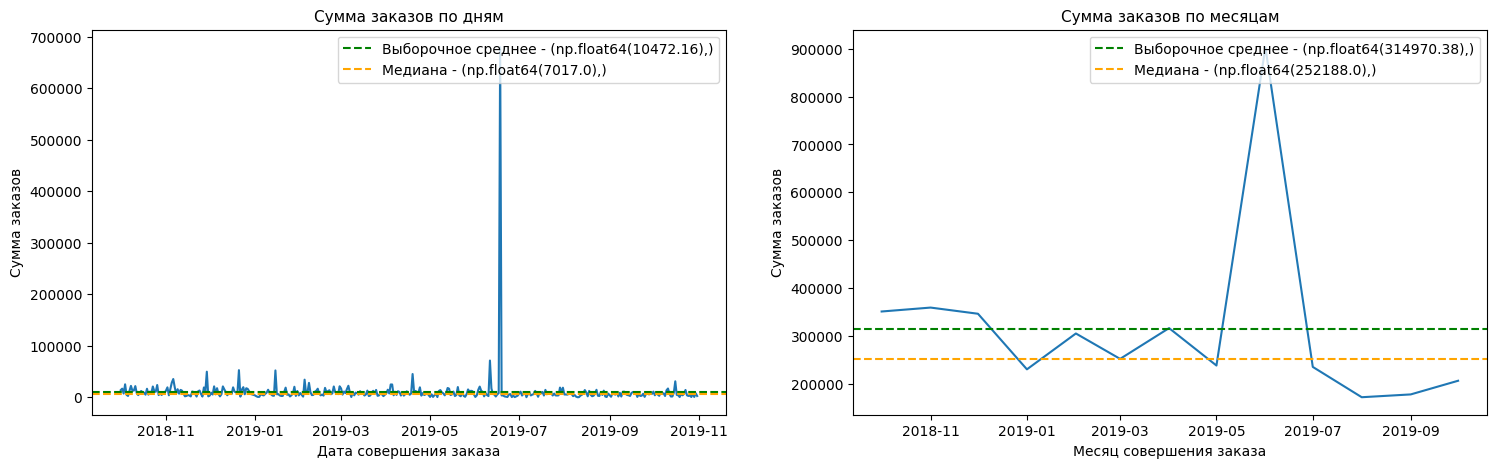

In [84]:
# по датам
plt.subplots(1,2, figsize=(18,5))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df_purchase,
                  x= 'event_data',
                  y= 'count_sum')

ax.set_xlabel('Дата совершения заказа')
ax.set_ylabel('Сумма заказов')
ax.set_title('Сумма заказов по дням', fontsize=11)

ax.axhline(df_purchase['count_sum'].mean(), linestyle='dashed', color='green',
            label=f'Выборочное среднее - {np.round(df_purchase['count_sum'].mean(), 2),}')
ax.axhline(df_purchase['count_sum'].median(), linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_purchase['count_sum'].median(), 2),}')
                        
plt.legend(loc='upper right')   

# по месяцам
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df_purchase_m,
                  x= 'event_month',
                  y= 'count_sum')

ax.set_xlabel('Месяц совершения заказа')
ax.set_ylabel('Сумма заказов')
ax.set_title('Сумма заказов по месяцам', fontsize=11)

ax.axhline(df_purchase_m['count_sum'].mean(), linestyle='dashed', color='green',
            label=f'Выборочное среднее - {np.round(df_purchase_m['count_sum'].mean(), 2),}')
ax.axhline(df_purchase_m['count_sum'].median(), linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_purchase_m['count_sum'].median(), 2),}')
                        
plt.legend(loc='upper right')  

In [85]:
df[df.order_id == 71743]

,date,customer_id,order_id,item,quantity,price,purchase_sum,count_order,event_data,event_month
3794,2019-06-18 01:05:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000,1,2019-06-18,2019-06-01


Видим некое выдающеемя значение.

При ближнем рассмотрении узнали, что это разовая покупка одной товарной единицы в большом количестве.

Попробуем исследовать данные без этого заказа.

In [86]:
df_purchase_1 = df[df.order_id != 71743].groupby('event_data')\
                                      .agg(count_sum = ('purchase_sum', 'sum'))\
                                      .reset_index()

df_purchase_m_1 = df[df.order_id != 71743].groupby('event_month')\
                                      .agg(count_sum = ('purchase_sum', 'sum'))\
                                      .reset_index()

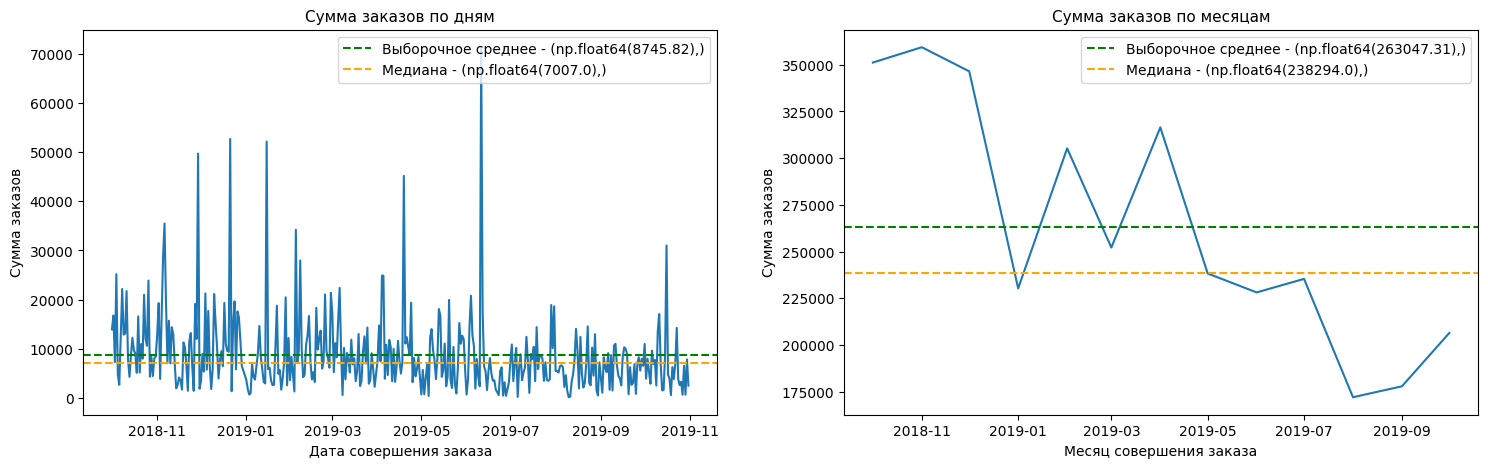

In [87]:
# по датам
plt.subplots(1,2, figsize=(18,5))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df_purchase_1,
                  x= 'event_data',
                  y= 'count_sum')

ax.set_xlabel('Дата совершения заказа')
ax.set_ylabel('Сумма заказов')
ax.set_title('Сумма заказов по дням', fontsize=11)

ax.axhline(df_purchase_1['count_sum'].mean(), linestyle='dashed', color='green',
            label=f'Выборочное среднее - {np.round(df_purchase_1['count_sum'].mean(), 2),}')
ax.axhline(df_purchase_1['count_sum'].median(), linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_purchase_1['count_sum'].median(), 2),}')
                        
plt.legend(loc='upper right')   

# по месяцам
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df_purchase_m_1,
                  x= 'event_month',
                  y= 'count_sum')

ax.set_xlabel('Месяц совершения заказа')
ax.set_ylabel('Сумма заказов')
ax.set_title('Сумма заказов по месяцам', fontsize=11)

ax.axhline(df_purchase_m_1['count_sum'].mean(), linestyle='dashed', color='green',
            label=f'Выборочное среднее - {np.round(df_purchase_m_1['count_sum'].mean(), 2),}')
ax.axhline(df_purchase_m_1['count_sum'].median(), linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_purchase_m_1['count_sum'].median(), 2),}')
                        
plt.legend(loc='upper right')  

Мы наблюдаем:

|Действие | Период|Вероятная причина
|:--|:--|:--|
|`пик активности` |  осень-начало зимы | планированием крупных покупок вне сезона отпусков  
|`пик активности` | февраль, апрель | подготовка к дачному сезону 
|`спад активности` | январь | период после праздников 
|`спад активности` | август-сентябрь | отпуска, учебный год 

Пиковый июнь с прошлого графика стал ниже медианного значения

Данные по ктябрю 2018 года кардинально отличаются от 2019 года (изменение ассотримента/условий покупки/доставки???)

- Построить гистограмму, отображающую распределение заказов по сумме.

Попробуем построить диаграмму, показывающую стоимость заказов. Поскольку количество заказов велико, выведем только заказы на сумму до 10000 рублей.

In [88]:
df_ordersum = df.groupby('order_id')\
                    .agg(count_sum = ('purchase_sum', 'sum'))\
                    .reset_index()

C:\Users\Анюта\AppData\Local\Temp\ipykernel_18948\332986747.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = 0)


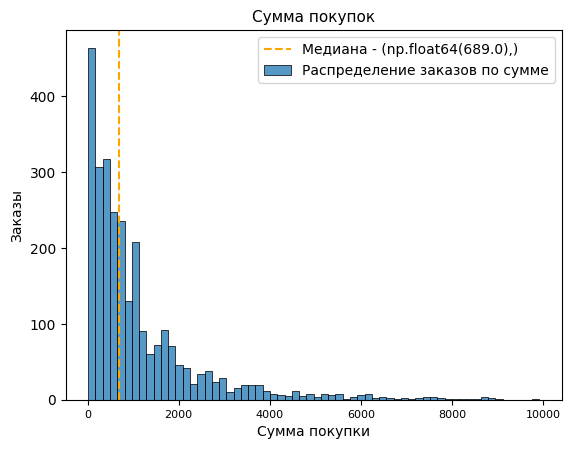

In [89]:
ax = sns.histplot(data=df_ordersum[df_ordersum.count_sum < 10000],
                  x='count_sum',
                  label='Распределение заказов по сумме')

ax.set_ylabel('Заказы')
ax.set_xlabel('Сумма покупки')
ax.set_title('Сумма покупок', fontsize=11)

ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = 0)
#ax.bar_label(ax.containers[0], label_type='edge', fontsize = 8, rotation = 90)  

ax.axvline(df_ordersum['count_sum'].median(),
            linestyle='dashed', color='orange',
            label=f'Медиана - {np.round(df_ordersum['count_sum'].median(), 2),}')
                        
plt.legend(loc='best') 


Видим, что очень много заказов по сумме до тысячи рублей.

Попробуем также визуализировать соотношение количества заказов (клиенты, сделавшие заказы n-раз) и суммы покупок по этим группам

In [90]:
df_n_ordersum = df.groupby('count_order')\
                  .agg(count_sum = ('purchase_sum', 'sum'))\
                  .reset_index()

C:\Users\Анюта\AppData\Local\Temp\ipykernel_18948\2195803664.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = 0)


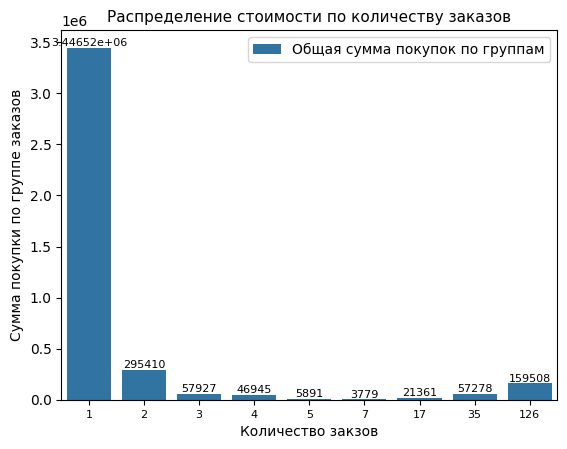

In [91]:
ax = sns.barplot(data=df_n_ordersum,
                     x = 'count_order',
                     y = 'count_sum',
                     label='Общая сумма покупок по группам')

ax.set_xlabel('Количество закзов')
ax.set_ylabel('Сумма покупки по группе заказов')
ax.set_title('Распределение стоимости по количеству заказов', fontsize=11)

ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = 0)
ax.bar_label(ax.containers[0], label_type='edge', fontsize = 8, rotation = 0)    
                        
plt.legend(loc='best')     

In [92]:
df[df.order_id != 71743].groupby('event_month')\
                                      .agg(count_sum = ('purchase_sum', 'sum'))\
                                      .reset_index()

,event_month,count_sum
0,2018-10-01,351162
1,2018-11-01,359348
2,2018-12-01,346449
3,2019-01-01,230336
4,2019-02-01,305242
5,2019-03-01,252188
6,2019-04-01,316469
7,2019-05-01,238294
8,2019-06-01,228176
9,2019-07-01,235410


##### <u>**Вывод:**</u>

На графике видно, что клиенты в основной массе делают по 1 покупке в этом магазине

На графиках выше видим некоторый спад, начиная с августа, однако сложно сделать вывод о том, насколько это характерно для данного магазина, мы не можем,   
поскольку база содержит данные только за один год.

Единственное, что мы заметили - существенная разница в показателях за октябрь в 2018 и 2019 годах.

Было бы интересно узнать, проходили ли в магазине какие-то изменения летом 2019 года.


##### Шаг 4. Анализ торгового асортимента
- На основании наименования товара и данных открытых внешних источников предложить 3-10 категорий товаров;
- В каждой категории распределить товары на основной и дополнительный ассортимент.

Для начала попробуем разделить ассоритемент на группы.

In [93]:
rastenya = ['арбуз', 'вербе', 'веник', 'базилик', 'диам', 'дыня', 'дробиум',  'калла', 'капуста', 'клубника',
            'космея', 'кашпо', 'лав', 'объем', 'огурец', 'пеларгония', 'петрушка', 'рассад', 'растени', 'роза', 
            'томат', 'd', '46600107', '465009', 'в горшке', 'в упаковке', 'в кассете', 'гиностемма', 'пятилист', 
            'коника', 'кодонанта', 'осина', 'бахромчатый', 'цикламен']

hoz_tovari = ['веревка','завертка', 'зажигал',  'инструмент', 'крепеж', 'котел', 'линейк', 'петля', 'напил', 
              'полировк', 'пружина', 'пепел', 'решетка', 'стремянк', 'сумка', 'стяжка', 'скоба', 'сварка', 
              'свер', 'тележк', 'уличн' , 'угольник', 'уголок', 'фиксатор-', 'фал ', 'циркуль', 'шило', 
              'шнур', 'шпагат', 'шпингалет']

kuhnia_posuda = [ 'банк', 'бидон', 'блюд', 'бульонница', 'бутыл','ваза', 'вилка', 'весы настол', 'венчик', 'емкость', 
                  'интер', 'кухон', 'ковш', 'картоф', 'кружк', 'кастрюля', 'контейнер', 'кувшин', 'кипятил', 'ложк', 
                  'лопатка', 'лоток', 'миска', 'миксер', 'нож', 'орех', 'отделитель', 'овощечистка',
                  'посуд',  'печ', 'половник', 'пресс для', 'противень', 'просеиватель', 'раздел', 'рыбо', 'рассекатель', 
                  'салатн', 'сковород', 'сахарница', 'скалк', 'стакан', 'соковыжималка', 'сотейник', 'тарелка', 'торт', 
                  'толкушк', 'терка', 'термос', 'фужер', 'хозлэнд', 'хлебн','чайник', 'штопор', 'яйц', 'luminarc', 'webber']

santechnika_uborka = ['белья', 'ванна ', 'вантуз ', 'ведр', 'веник', 'гладил', 'для ван', 'ерш', 'ёрш', 'жир', 'зуб', 
                      'корзина', 'корыто', 'кольца', 'мыл', 'мусор', 'насадка ', 'насадка-', 'отбеливатель', 'окномойка',
                      'ополаскиватель', 'прищеп', 'перчат', 'подкладк', 'пробк', 'подголовник', 'пылесос',
                      'рукав', 'ролик', 'сушилк', 'сиденье', 'средств', 'стир', 'совок', 'сетка', 'скребок', 'соль', 
                      'сметка', 'таз', 'тряпк', 'туалет', 'ткань', 'утюг', 'швабра', 'щетка', 'euroh', 'mama', 
                      ' R21', 'clean', 'reflector', 'маска ', '1108416']

obstanovka_textil= ['вешал', 'весы напол', 'для одежд', 'искусст', 'искуств', 'короб', 'коврик', 'ковер', 'ковёр', 
                    'кофр', 'комод', 'костюм', 'карниз', 'ключ', 'крючок', 'муляж', 'наматр', 'наволочк', 'одеял', 
                    'обув', 'платья', 'полк', 'плечи', 'полотен', 'простын',  'покрыв', 'пуф', 'почт', 'плед', 
                    'постель', 'подушк', 'светильник', 'салфет', 'скатерть', 'хранен', 'халат', 'фоторамка', 
                    'фен ', 'этажер', 'короткой', '1-секц']

rastenya_1 = ['ола полка', 'зев', 'коника', 'нарцисс 5']

In [94]:
sdv = df.item.str.lower().str.contains('|'.join(rastenya))
hztvr = df.item.str.lower().str.contains('|'.join(hoz_tovari))
khn = df.item.str.lower().str.contains('|'.join(kuhnia_posuda))
txtl = df.item.str.lower().str.contains('|'.join(obstanovka_textil))
sntch = df.item.str.lower().str.contains('|'.join(santechnika_uborka))
sdv_1 = df.item.str.lower().str.contains('|'.join(rastenya_1))

df.loc[sdv, "category"] = "Растения" 
df.loc[hztvr, "category"] = "Хозтовары" 
df.loc[khn, "category"] = "Кухонная утварь" 
df.loc[txtl, "category"] = "Декор и уют" 
df.loc[sntch, "category"] = "Сантехника и чистота" 
df.loc[sdv_1, "category"] = "Растения" 

df.head(10)

,date,customer_id,order_id,item,quantity,price,purchase_sum,count_order,event_data,event_month,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142,1,2018-10-01,2018-10-01,Растения
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194,1,2018-10-01,2018-10-01,Растения
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112,1,2018-10-01,2018-10-01,Растения
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179,1,2018-10-01,2018-10-01,Растения
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112,1,2018-10-01,2018-10-01,Растения
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,164,1,2018-10-01,2018-10-01,Растения
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,134,1,2018-10-01,2018-10-01,Растения
7,2018-10-01 00:08:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,824,1,2018-10-01,2018-10-01,Сантехника и чистота
8,2018-10-01 00:08:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,269,1,2018-10-01,2018-10-01,Сантехника и чистота
9,2018-10-01 00:09:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,674,126,2018-10-01,2018-10-01,Сантехника и чистота


In [95]:
# разбивка по группам

df['category'].unique()
df['category'].value_counts() 

category
Растения                2488
Сантехника и чистота     917
Декор и уют              624
Хозтовары                446
Кухонная утварь          332
Name: count, dtype: int64

In [96]:
df.item.nunique()

2331

Изначально планировалось сделать разбивку на основной и дополнительный товары вручную, поскольку для меня прикассовый товар - 

это не только дешевый товар, но и тот, который может зацепить глаз - подарочные наборы (к очередному празднику), сменные элементы чего-либо

Но вариант преподавателя более автоматизированный, потому используем его.

In [97]:
# дополнительный товар -- товар по каждой категории, стоимость которого не превышает модальной стоимости товара по категории.
# так учтем и цену и частоту
# напишем функцию разделению разделения
def get_additional_product(row):

    name_category = row['category']
    if row['price'] <= np.min(df[df.category == name_category].price.mode()):
        return 'Дополнительный'
    else:
        return 'Основной'

In [98]:
df['item_category'] = df.apply(get_additional_product, axis=1)
df.head(2)

,date,customer_id,order_id,item,quantity,price,purchase_sum,count_order,event_data,event_month,category,item_category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142,1,2018-10-01,2018-10-01,Растения,Основной
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194,1,2018-10-01,2018-10-01,Растения,Основной


In [99]:
df[df['item_category'] == 'Основной']['category'].value_counts()
df[df['item_category'] == 'Дополнительный']['category'].value_counts()

category
Сантехника и чистота    394
Растения                350
Декор и уют             244
Хозтовары               243
Кухонная утварь          17
Name: count, dtype: int64

Шаг 5. Статистические гипотезы
- Сформулировать и проверить статистические гипотезы о равенстве средних чеков для выделенных категорий товаров.

In [100]:
# рассчитаем для каждой катеории сумма заказа

df_to_hyp = df.groupby(['category', 'order_id'])\
  .agg(sum_order=('purchase_sum', 'sum'))\
  .reset_index()

Поскольку мы уже выяснили, что группа товаров 'Растения' самая большая по количеству номенклатурных позиций,

то в качестве эсперимента сравним средние чеки этой группы с другими.

Создаем гипотезы по законам распределения для каждого признака,  для этого формируем выборки для каждого признака

- H_0 -- F(x) -- имеет нормальный закон распределения
- H_1 -- F(x) -- имеет закон распределения, отличный от нормального
- H_0 -- F(y) -- имеет нормальный закон распределения
- H_1 -- F(y) -- имеет закон распределения, отличный от нормального

Наша выборка меньше 5000, потому для проверки гипотезы о нормальности можем использовать критерий Шапиро-Уилкса

In [101]:
# формируем выборки и проверяем выборки

lst_cat = ['Сантехника и чистота', 'Декор и уют', 'Кухонная утварь', 'Хозтовары']
for cat_type in lst_cat:
    x = df_to_hyp[df_to_hyp['category'] == 'Растения'].sum_order
    y= df_to_hyp[df_to_hyp['category'] == cat_type].sum_order
    alpha = 0.05
    statist, p_valye = shapiro(y, nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = {p_valye}""")
        print()      
    else:
        print(f"""Гипотезу H_0 примимаем, распределение `y` нормальное.
p-value = {p_valye}""")
        print() 

Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 8.024993144553752e-54

Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 1.2946441422853096e-39

Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 8.273809579848877e-32

Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 3.7999065519061514e-31



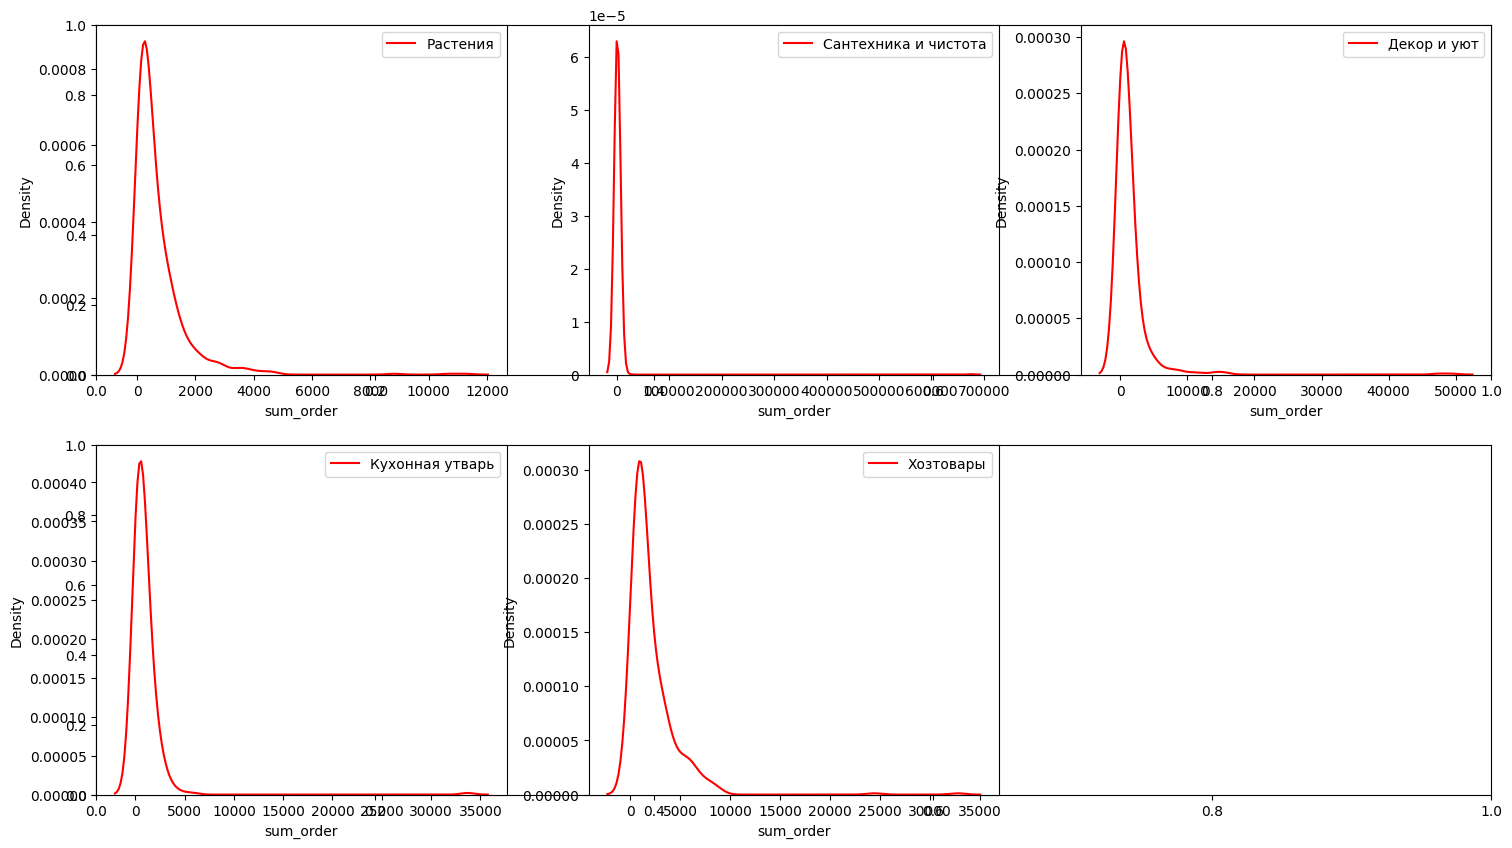

In [102]:
# построим график плотности
lst_cat = ['Растения', 'Сантехника и чистота', 'Декор и уют', 'Кухонная утварь', 'Хозтовары']

fig, ax = plt.subplots(2, figsize = (18,10))

for index, cat_type in enumerate(lst_cat, start = 1):
    plt.subplot(2, 3, index)
    y= df_to_hyp[df_to_hyp['category'] == cat_type].sum_order
    sns.kdeplot(x=y, color='red', label = cat_type)
    plt.legend()

Поскольку один из признаков имеет распределение, отличное от нормального, 

проверяем статистики с помощью критерия Манна-Уитни

In [103]:
lst_cat = ['Сантехника и чистота', 'Декор и уют', 'Кухонная утварь', 'Хозтовары']
for cat_type in lst_cat:
    x = df_to_hyp[df_to_hyp['category'] == 'Растения'].sum_order
    y= df_to_hyp[df_to_hyp['category'] == cat_type].sum_order
    alpha = 0.05
    statist, p_valye = mannwhitneyu(x, y,
                                    nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу о равенстве средних чеков для категорий 'Растения' и '{cat_type}' отвергаем.
p-value = {p_valye}""")
        print(f'x.mean = {x.mean().round(2)}, x.mean = {y.mean().round(2)}')
        print()
    else:
        print(f"""Гипотезу о равенстве средних чеков для категорий 'Растения' и '{cat_type}' примимаем.
p-value = {p_valye}""") 
        print() 

Гипотезу о равенстве средних чеков для категорий 'Растения' и 'Сантехника и чистота' отвергаем.
p-value = 1.5835949050335207e-34
x.mean = 698.76, x.mean = 2026.74

Гипотезу о равенстве средних чеков для категорий 'Растения' и 'Декор и уют' отвергаем.
p-value = 1.5464812584072386e-05
x.mean = 698.76, x.mean = 1393.9

Гипотезу о равенстве средних чеков для категорий 'Растения' и 'Кухонная утварь' отвергаем.
p-value = 0.0004283459433401505
x.mean = 698.76, x.mean = 931.44

Гипотезу о равенстве средних чеков для категорий 'Растения' и 'Хозтовары' отвергаем.
p-value = 8.879871073586327e-65
x.mean = 698.76, x.mean = 2088.9



##### <u>**Вывод:**</u>

Средние чеки группы товаров 'Растения' отличаются от средних чеков других товарных групп.

Это не стало сюрпризом, поскольку именно группа товаров 'Растения' содержит большое количество позиций с минимальными для выборки ценами.

Шаг 6. Дашборд

In [104]:
df.to_excel('vkr.xlsx')

[Ссылка](https://datalens.yandex/xbaygv8x6q00k) на дашборд